# Bank Marketing Classification

## Data Collection/Preprocessing

Carolyn
- Load data
- Feature analysis (check for imbalanced data, heatmap feature correlation, etc.)

Jonathan
- Feature engineering (feature scaling, normalization, standardization, one hot encode features/targets, check for missing values)
- Train test validation split

In [2]:
import sklearn
import tensorflow
import pandas as pd
import numpy as np
import matplotlib as plt

# !pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

In [3]:
# import the dataset -- can use pip install

# # fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# # data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# # metadata 
print(bank_marketing.metadata) 
  
# # variable information 
print(bank_marketing.variables) 

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'title': 'A data-driven approach to predict the success of bank telemarketing'

In [4]:
# set seed
seed = 42

In [5]:
# Drop any duplicates (none)

X = X.drop_duplicates()

# Checking for NA columns
for col in X.columns:
    if not X[col].notna().all():
        print(f'NA for {col}')
        print(X[col].value_counts(dropna=False))

# Problems to address: 1) 288 null in occupation (impute with mode), 2) 1857 null in education (get rid of or impute?) CHECK, 3) NaN contact label as new category 'other' CHECK, 4) poutcome NaN and other become unknown         
X['job'] = X['job'].mask(X['job'].isna(), 'blue-collar')
X['education'] = X['education'].mask(X['education'].isna(), 'secondary')
X['contact'] = X['contact'].mask(X['contact'].isna(), 'other')
X['poutcome'] = X['poutcome'].mask(X['poutcome'].isna(), 'unknown')
X['poutcome'] = X['poutcome'].mask(X['poutcome'] == 'other', 'unknown')
X.info()
print(X['job'].value_counts(dropna=False))

# Binarize target
y = pd.DataFrame(np.where(y == 'yes', 1, 0))
y.value_counts(dropna=False)

# pdays binning

bins = [float('-inf'), -1, 90, 180, 365, float('inf')]
labels = [0, 1, 2, 3, 4]
# bins to corresponding label
pdays_b2l = {0: 'never prev contacted', 1: '1-90 days', 2: '91-180 days', 3: '181-365 days', 4: '> 365 days'}

# Bin the pdays column
X['pdays_bin'] = pd.cut(X['pdays'], bins=bins, labels=labels)

# Check the distribution of bins
bin_counts = X['pdays_bin'].value_counts()
# print(bin_counts)

# age binning

bins = [18, 30, 40, 50, 60, float('inf')]
labels = [0, 1, 2, 3, 4]
# bins to corresponding label
age_b2l = {0: '18-30', 1: '31-40', 2: '41-50', 3: '51-60', 4: '61+'}

# Bin the age column
X['age_bin'] = pd.cut(X['age'], bins=bins, labels=labels, include_lowest=True)

# Check the distribution of bins
bin_counts = X['age_bin'].value_counts()
# print(bin_counts)

# balance binning

bins = [float('-inf'), 0, 500, 1000, 5000, 10000, float('inf')]
labels = [0, 1, 2, 3, 4, 5]
# bins to corresponding label
bal_b2l = {0: '< 0', 1: '0-500', 2: '501-1000', 3: '1001-5000', 4: '5001-10000', 5: '10001+'}

# Bin the balance column
X['bal_bin'] = pd.cut(X['balance'], bins=bins, labels=labels)

# Check the distribution of bins
bin_counts = X['bal_bin'].value_counts()
# print(bin_counts)

# campaign binning

bins = [1, 2, 5, 10, float('inf')]
labels = [0, 1, 2, 3]
# bins to corresponding label
camp_b2l = {0: '1', 1: '2-5', 2: '6-10', 3: '10+'}

# Bin the pdays column
X['camp_bin'] = pd.cut(X['campaign'], bins=bins, labels=labels, include_lowest=True)

# Check the distribution of bins
bin_counts = X['camp_bin'].value_counts()
# print(bin_counts)

# previous binning

bins = [float('-inf'), 0, 1, 5, float('inf')]
labels = [0, 1, 2, 3]
# bins to corresponding label
prev_b2l = {0: '0', 1: '1', 2: '2-5', 3: '6+'}

# Bin the pdays column
X['prev_bin'] = pd.cut(X['previous'], bins=bins, labels=labels)

# Check the distribution of bins
bin_counts = X['prev_bin'].value_counts()
# print(bin_counts)


X_archive = X

# Remove duration, day_of_week, month, duration (not useful for meaningful prediction), and all columns just binned
X = X.drop(columns=['month','duration', 'day_of_week', 'age', 'campaign', 'balance', 'pdays', 'previous'])

for col in X.columns:
    X[col] = X[col].mask(X[col] == 'yes', 1)
    X[col] = X[col].mask(X[col] == 'no', 0)
    X[col] = X[col].astype('category')
y = y.astype('float64').to_numpy()

# Check distribution and data types of each column
for col in X.columns:
    print(X[col].value_counts(dropna=False))
X.info()

# One-Hot-Encoding every column
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
X_ohe = ohe.fit_transform(X).toarray()

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, test_size = 0.15, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1275, random_state=seed)

NA for job
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
NaN               288
Name: count, dtype: int64
NA for education
education
secondary    23202
tertiary     13301
primary       6851
NaN           1857
Name: count, dtype: int64
NA for contact
contact
cellular     29285
NaN          13020
telephone     2906
Name: count, dtype: int64
NA for poutcome
poutcome
NaN        36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          45211 non-null  object
 2   marital      45211 non-null  object
 3   education    45211 non

In [6]:
# Showing proportion of the no (first number) and yes (second number) for each split. Would recommend looking into ways of mitigating unbalanced class proportions

_, counts = np.unique(y_test, return_counts=True)
print(counts)

_, counts = np.unique(y_val, return_counts=True)
counts
print(counts)

_, counts = np.unique(y_train, return_counts=True)
print(counts)

[5970  812]
[4349  551]
[29603  3926]


## Baselines

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score
y_train_1d = y_train.ravel()

### Baseline Test: Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train_1d)

y_pred_log = log_reg_model.predict(X_test)

logistic_regression_accuracy = accuracy_score(y_test, y_pred_log)
print("Accuracy of Logistic Regression:", logistic_regression_accuracy)

Accuracy of Logistic Regression: 0.8911825420230021


### Baseline Test: Random Guessing

In [9]:
# Assuming y_train contains the target labels of the training set
# Generate random predictions based on the distribution of the target variable
random_predictions = np.random.choice([0, 1], size=len(y_test), p=[1-np.mean(y_train), np.mean(y_train)])

# Evaluate the performance of the random guessing model
accuracy = accuracy_score(y_test, random_predictions)
print("Accuracy of random guessing model:", accuracy)


Accuracy of random guessing model: 0.7960778531406665


### Baseline Test: Dummy Classifier

In [10]:
from sklearn.dummy import DummyClassifier

# Create a DummyClassifier with strategy='stratified' to perform random guessing
dummy_classifier = DummyClassifier(strategy='stratified', random_state=42)

# Train the DummyClassifier on the training data
dummy_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dummy_classifier.predict(X_test)

# Evaluate the performance of the DummyClassifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of DummyClassifier (random guessing):", accuracy)

Accuracy of DummyClassifier (random guessing): 0.7959304040106163


## Training Model

#### Ensemble Model

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=seed)
rf_model.fit(X_train, y_train_1d)
y_pred_rf = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest:", rf_accuracy)

# check using balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_rf)
print("Balanced Accuracy of Random Forest:", balanced_accuracy)

Accuracy of Random Forest: 0.8920672368033029
Balanced Accuracy of Random Forest: 0.5790537251116007


In [15]:
# pip install xgboost
import xgboost as xgb

xgb_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=seed)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

# check using balanced accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_xgb)
print("Balanced Accuracy of Random Forest:", balanced_accuracy)

XGBoost Accuracy: 0.8923621350634031
Balanced Accuracy of Random Forest: 0.5834773209231708


### Simple Neural Network

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the neural network architecture
neural_net = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),  # Add dropout with a rate of 0.2
    Dense(32, activation='relu'),
    Dropout(0.2),  # Add dropout with a rate of 0.2
    Dense(1, activation='sigmoid')
])

# Compile the model
neural_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Train the model
history = neural_net.fit(X_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = neural_net.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Epoch 1/20


/opt/anaconda3/envs/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1048/1048 ━━━━━━━━━━━━━━━━━━━━ 1s 545us/step - accuracy: 0.8756 - loss: 0.3483 - val_accuracy: 0.8927 - val_loss: 0.3029
Epoch 2/20
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.8943 - loss: 0.3072 - val_accuracy: 0.8973 - val_loss: 0.2979
Epoch 3/20
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.8932 - loss: 0.3110 - val_accuracy: 0.8957 - val_loss: 0.2980
Epoch 4/20
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.8925 - loss: 0.3073 - val_accuracy: 0.8973 - val_loss: 0.2981
Epoch 5/20
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 1s 491us/step - accuracy: 0.8916 - loss: 0.3111 - val_accuracy: 0.8965 - val_loss: 0.3011
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - accuracy: 0.8859 - loss: 0.3284
Test Accuracy: 0.8919197916984558


## Evaluating Model

In [29]:
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def calculate_f1_score(model, model_name, X, y_true):
    y_pred = model.predict(X)
    # convert to binary probability for neural networks
    y_pred = (y_pred > 0.5).astype(int)
    score = f1_score(y_true, y_pred)
    print(f"F1 Score of {model_name}: {score}")

def display_roc(model, X, y_true):
    y_pred = model.predict(X)
    # convert to binary probability for neural networks
    y_pred = (y_pred > 0.5).astype(int)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate Area Under the ROC Curve (AUC)
    auc = roc_auc_score(y_test, y_pred)
    print("Area Under ROC Curve (AUC):", auc)
    print()

F1 Score of Random Forest: 0.27091633466135456


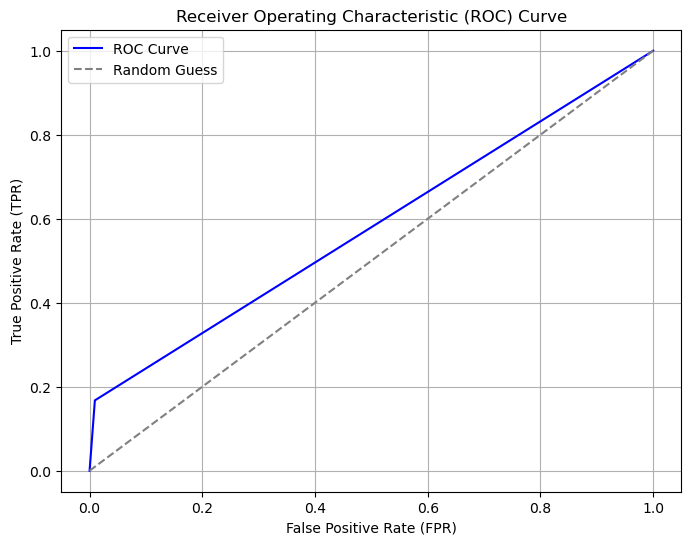

Area Under ROC Curve (AUC): 0.5790537251116007

F1 Score of XGBoost: 0.2829076620825147


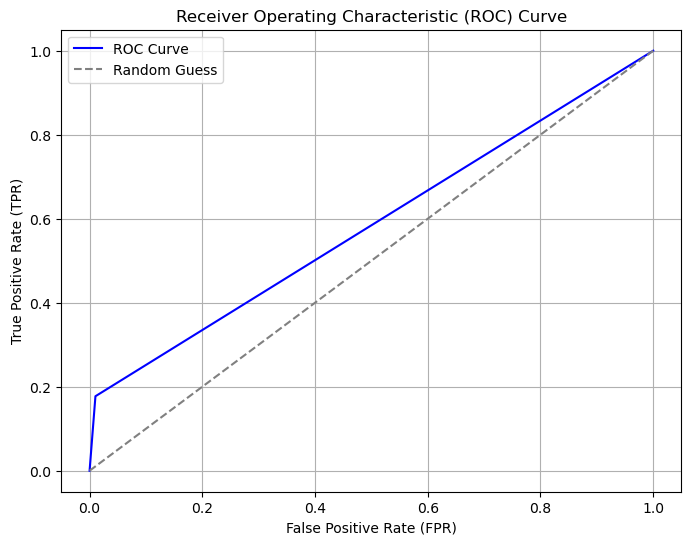

Area Under ROC Curve (AUC): 0.5834773209231708

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
F1 Score of Neural Network: 0.2945139557266602
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step


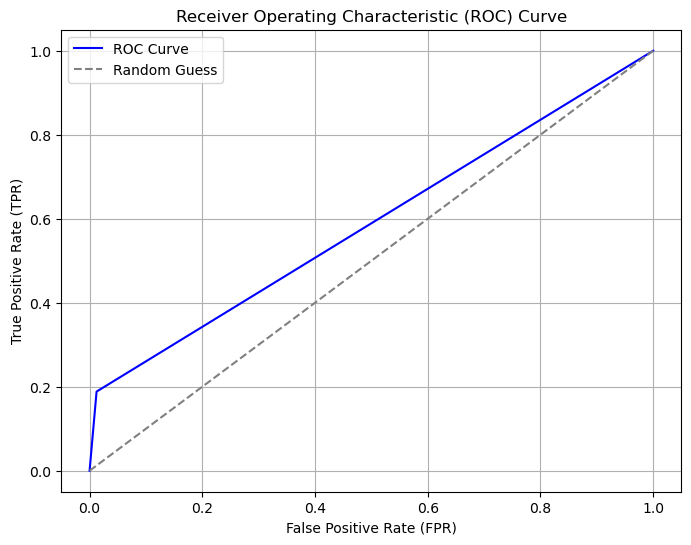

Area Under ROC Curve (AUC): 0.5880141677187251



In [30]:

calculate_f1_score(rf_model, "Random Forest", X_test, y_test)
display_roc(rf_model, X_test, y_test)

calculate_f1_score(xgb_model, "XGBoost", X_test, y_test)
display_roc(xgb_model, X_test, y_test)

calculate_f1_score(neural_net, "Neural Network", X_test, y_test)
display_roc(neural_net, X_test, y_test)
